In [1]:
# Step 1 - Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [8]:
train_path = r"C:\Users\Dell\Documents\ASL_Detection\data\asl_alphabet_train"
test_path = r"C:\Users\Dell\Documents\ASL_Detection\data\asl_alphabet_test"

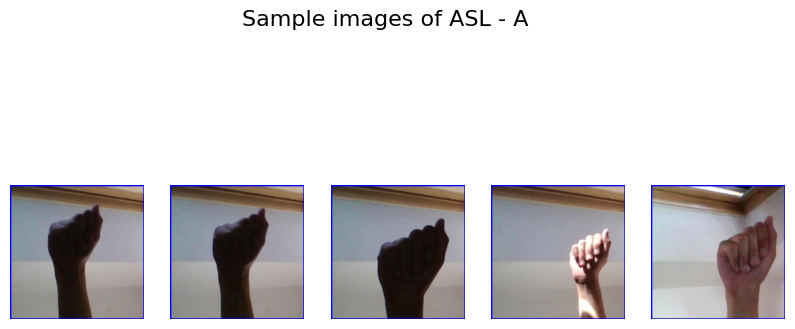

In [9]:
sample_folder = os.path.join(train_path, 'A')
sample_images = os.listdir(sample_folder)[:5]

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(sample_folder, img_name)
    img = plt.imread(img_path)
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample images of ASL - A', fontsize=16)
plt.show()


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalize pixels
    rotation_range=15,       # rotate randomly
    width_shift_range=0.1,   # horizontal shift
    height_shift_range=0.1,  # vertical shift
    zoom_range=0.1,          # random zoom
    horizontal_flip=True,    # flip horizontally
    fill_mode='nearest',     # fill in missing pixels
    validation_split=0.2     # 20% data for validation
)

# Test/validation generator - only rescaling
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


In [11]:
# Training generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'   # use 80% for training
)

# Validation generator
val_generator = test_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # use 20% for validation
)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 with pre-trained ImageNet weights, exclude top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(29, activation='softmax')(x)  # 29 classes

# Define final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃   Param # ┃ Connected to     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ input_layer        │ (None, 224, 224, │         0 │ -                │
│ (InputLayer)       │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ Conv1 (Conv2D)     │ (None, 112, 112, │       864 │ input_layer[0][… │
│                    │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ bn_Conv1           │ (None, 112, 112, │       128 │ Conv1[0][0]      │
│ (BatchNormalizati… │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ Conv1_relu (ReLU)  │ (None, 112, 112, │         0 │ bn_Conv1[0][0]   │
│                    │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ expanded_conv_dep… │ (None, 112, 112, │       288 │ Conv1_relu[0][0] │
│ (DepthwiseConv2D)  │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ expanded_conv_dep… │ (None, 112, 112, │       128 │ expanded_conv_d… │
│ (BatchNormalizati… │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ expanded_conv_dep… │ (None, 112, 112, │         0 │ expanded_conv_d… │
│ (ReLU)             │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ expanded_conv_pro… │ (None, 112, 112, │       512 │ expanded_conv_d… │
│ (Conv2D)           │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ expanded_conv_pro… │ (None, 112, 112, │        64 │ expanded_conv_p… │
│ (BatchNormalizati… │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_expand     │ (None, 112, 112, │     1,536 │ expanded_conv_p… │
│ (Conv2D)           │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_expand_BN  │ (None, 112, 112, │       384 │ block_1_expand[… │
│ (BatchNormalizati… │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_expand_re… │ (None, 112, 112, │         0 │ block_1_expand_… │
│ (ReLU)             │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_pad        │ (None, 113, 113, │         0 │ block_1_expand_… │
│ (ZeroPadding2D)    │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_depthwise  │ (None, 56, 56,   │       864 │ block_1_pad[0][… │
│ (DepthwiseConv2D)  │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_depthwise… │ (None, 56, 56,   │       384 │ block_1_depthwi… │
│ (BatchNormalizati… │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_depthwise… │ (None, 56, 56,   │         0 │ block_1_depthwi… │
│ (ReLU)             │ 96)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_project    │ (None, 56, 56,   │     2,304 │ block_1_depthwi… │
│ (Conv2D)           │ 24)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block_1_project_BN │ (None, 56, 56,   │        96 │ bloc

 Total params: 2,425,693 (9.25 MB)

 Trainable params: 167,709 (655.11 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,         # you can increase later for better accuracy
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)


C:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 3513s 2s/step - accuracy: 0.8400 - loss: 0.5226 - val_accuracy: 0.8099 - val_loss: 0.6437
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 6806s 3s/step - accuracy: 0.9136 - loss: 0.2634 - val_accuracy: 0.8077 - val_loss: 0.6944
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 4572s 2s/step - accuracy: 0.9269 - loss: 0.2237 - val_accuracy: 0.8239 - val_loss: 0.6716
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 3620s 2s/step - accuracy: 0.9348 - loss: 0.1971 - val_accuracy: 0.8046 - val_loss: 0.7557
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 3058s 1s/step - accuracy: 0.9399 - loss: 0.1809 - val_accuracy: 0.8115 - val_loss: 0.7254
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 3055s 1s/step - accuracy: 0.9442 - loss: 0.1669 - val_accuracy: 0.8237 - val_loss: 0.6628
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 3179s 1s/step - accuracy: 0.9476 - loss: 0.1581 - val_accuracy: 0.8203 - val_loss: 0.6814
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 2910s 1s/step - accuracy: 0.9502 -

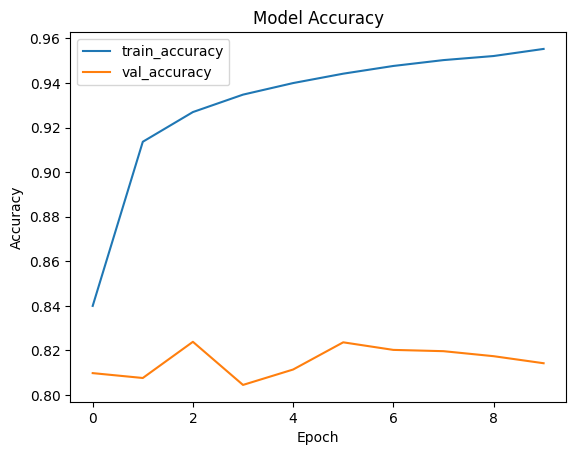

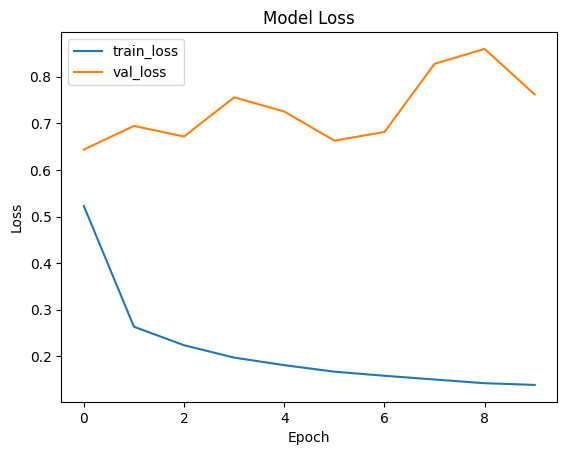

In [14]:
# Plot accuracy and loss
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


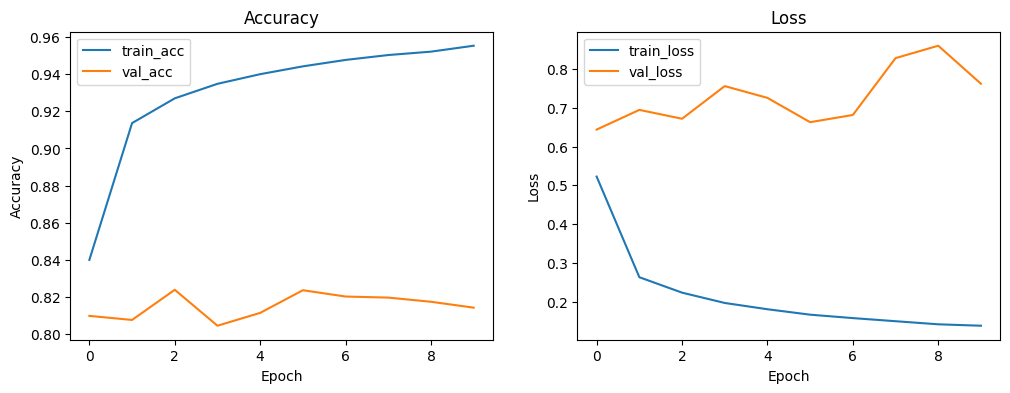

In [15]:
# Plot training history (accuracy & loss)
import matplotlib.pyplot as plt

# history from model.fit(...) must exist
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [16]:
IMG = 160  # or 224 — whatever you used
BATCH = 32 # match your earlier batch size

from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    train_path,                 # same folder you trained from
    target_size=(IMG, IMG),
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation',
    shuffle=False               # critical for matching preds -> true labels
)

print("Validation samples:", val_generator.samples)


Found 17400 images belonging to 29 classes.
Validation samples: 17400


In [17]:
# Evaluate (gives loss & accuracy)
val_loss, val_acc = model.evaluate(val_generator, steps=val_generator.samples // BATCH, verbose=1)
print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")


543/543 ━━━━━━━━━━━━━━━━━━━━ 524s 956ms/step - accuracy: 0.7230 - loss: 1.6460
Validation loss: 1.6460, Validation accuracy: 0.7230


In [19]:
# Inspect model input shape
print("Model input shape:", model.input_shape)   # e.g. (None, 224, 224, 3)

# derive expected IMG size
_, IMG_H, IMG_W, _ = model.input_shape
IMG = IMG_H  # assume square images
print("Using IMG =", IMG)

Model input shape: (None, 224, 224, 3)
Using IMG = 224


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH = 32   # set to whatever batch you used for validation (match earlier)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# recreate validation generator with the exact target_size the model expects
val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG, IMG),   # MATCHES model input
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Validation generator image shape will be:", (BATCH, IMG, IMG, 3))


Found 17400 images belonging to 29 classes.
Validation generator image shape will be: (32, 224, 224, 3)


In [21]:
import numpy as np

steps = int(np.ceil(val_generator.samples / BATCH))
pred_probs = model.predict(val_generator, steps=steps, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)

true_labels = val_generator.classes
print("Predictions done. #preds:", len(pred_labels), "#true:", len(true_labels))


544/544 ━━━━━━━━━━━━━━━━━━━━ 735s 1s/step
Predictions done. #preds: 17400 #true: 17400


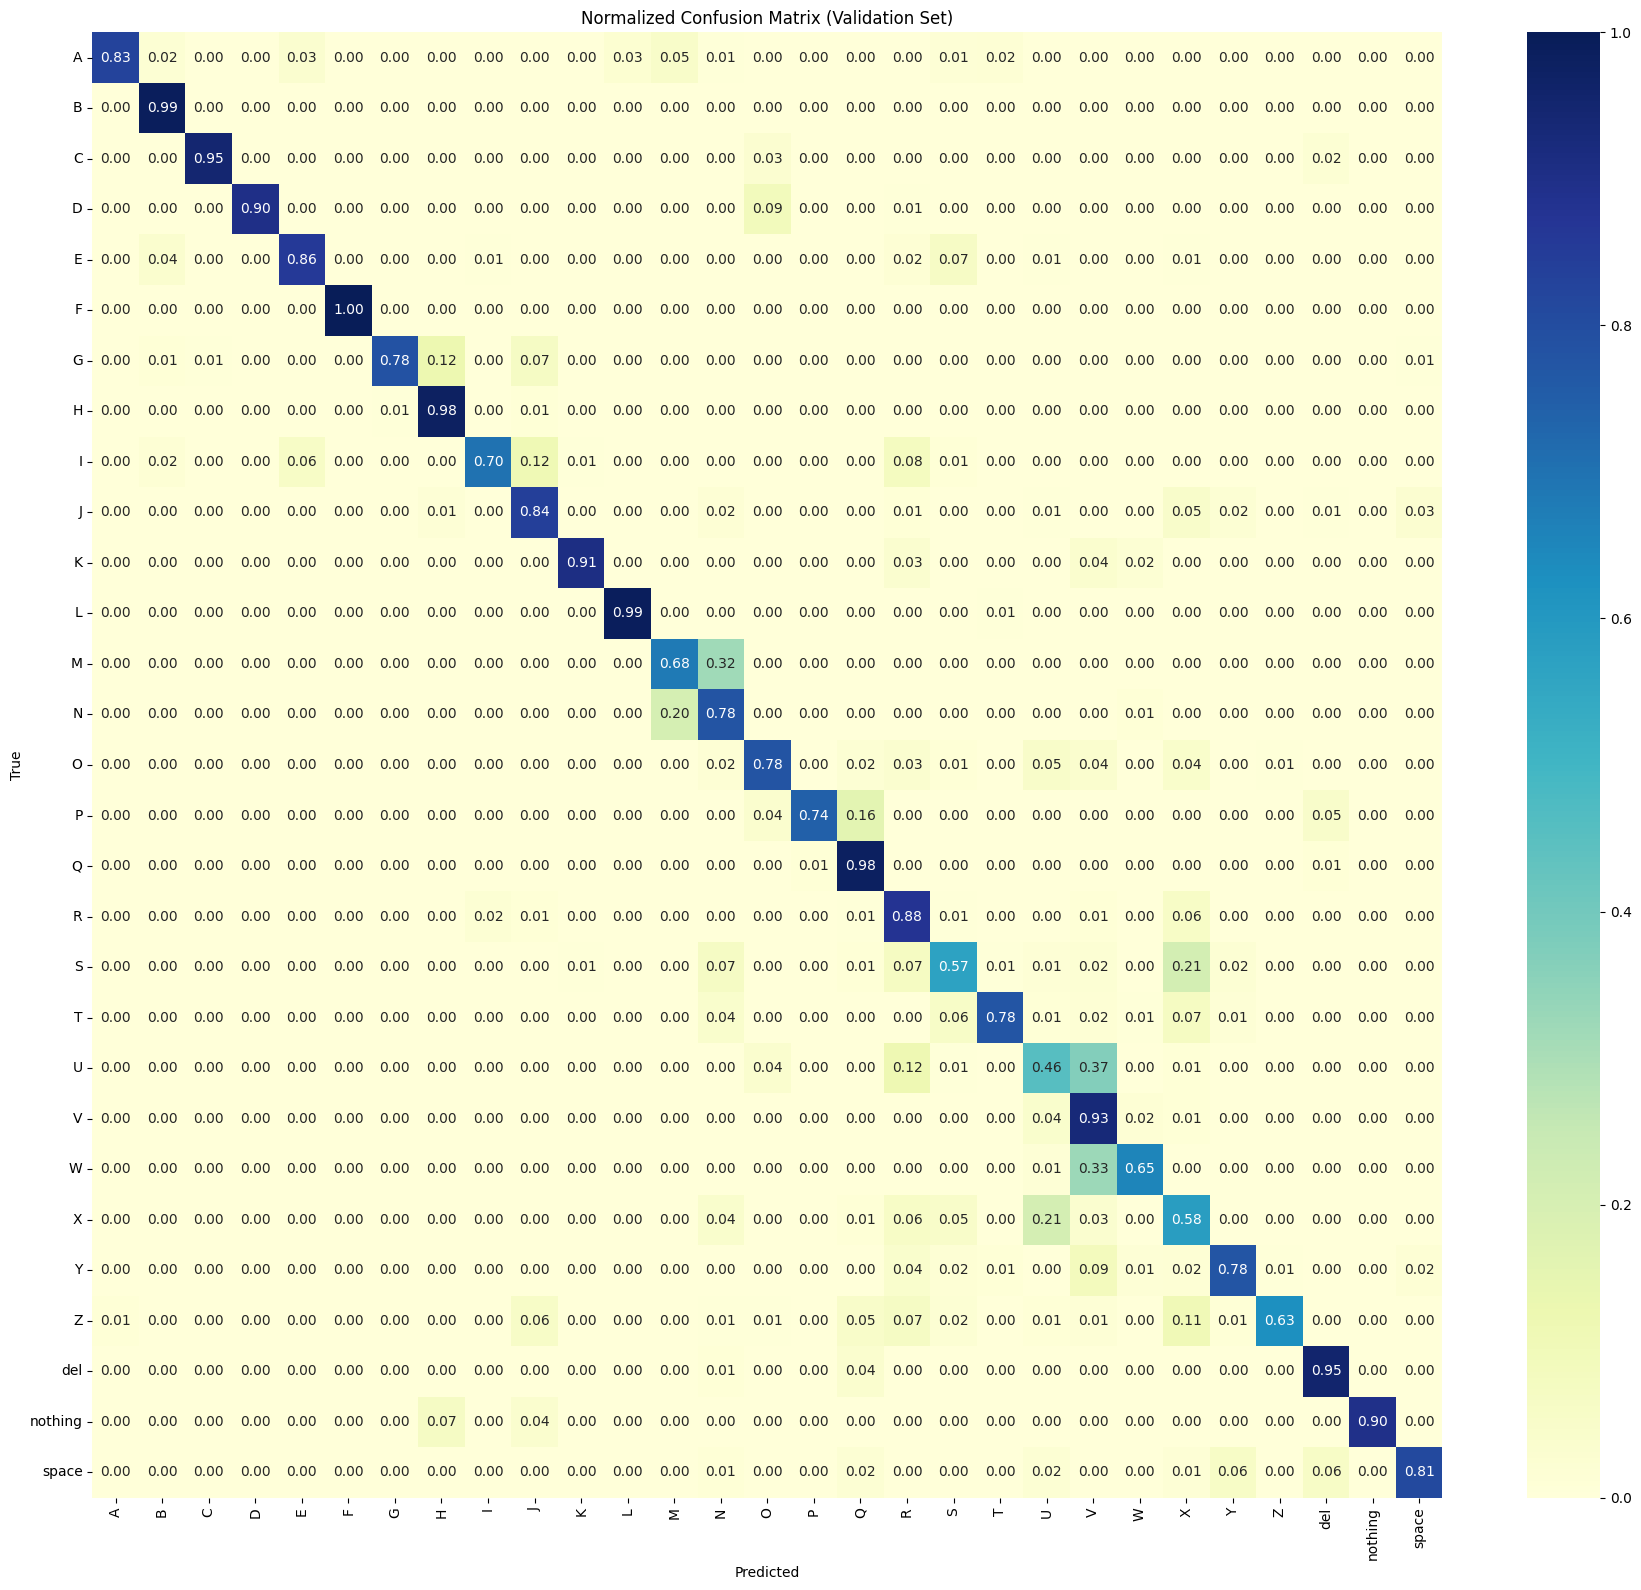

Saved confusion_matrix_normalized.png


In [25]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
true_labels = val_generator.classes
pred_labels = np.argmax(pred_probs, axis=1)
cm = confusion_matrix(true_labels, pred_labels)

# Normalize to percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Class names
target_names = list(val_generator.class_indices.keys())

# Plot normalized confusion matrix
plt.figure(figsize=(18,16))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlGnBu', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (Validation Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=150)
plt.show()

print("Saved confusion_matrix_normalized.png")



In [26]:
import numpy as np
import pandas as pd

# true_labels and pred_labels must exist from earlier
# target_names already defined

# Per-class counts
classes = target_names
num_classes = len(classes)

per_class_acc = []
for i, cls in enumerate(classes):
    idxs = np.where(true_labels == i)[0]
    if len(idxs) == 0:
        acc = np.nan
    else:
        acc = (pred_labels[idxs] == i).sum() / len(idxs)
    per_class_acc.append((cls, len(idxs), acc))

df_acc = pd.DataFrame(per_class_acc, columns=['class','support','accuracy'])
df_acc = df_acc.sort_values(by='accuracy')  # lowest accuracy first
df_acc.reset_index(drop=True, inplace=True)
df_acc.head(15)


class  support  accuracy
0       U      600  0.456667
1       S      600  0.566667
2       X      600  0.585000
3       Z      600  0.626667
4       W      600  0.653333
5       M      600  0.680000
6       I      600  0.701667
7       P      600  0.745000
8       T      600  0.776667
9       Y      600  0.776667
10      N      600  0.778333
11      O      600  0.780000
12      G      600  0.781667
13  space      600  0.810000
14      A      600  0.828333

In [27]:
k = 10
print("Top", k, "worst-performing classes (by accuracy):\n")
print(df_acc.head(k).to_string(index=False))


Top 10 worst-performing classes (by accuracy):

class  support  accuracy
    U      600  0.456667
    S      600  0.566667
    X      600  0.585000
    Z      600  0.626667
    W      600  0.653333
    M      600  0.680000
    I      600  0.701667
    P      600  0.745000
    T      600  0.776667
    Y      600  0.776667


In [28]:
from collections import Counter

# pick the worst class (first row of df_acc)
worst_class = df_acc.loc[0, 'class']
worst_idx = classes.index(worst_class)
idxs = np.where(true_labels == worst_idx)[0]
wrong_preds = pred_labels[idxs][pred_labels[idxs] != worst_idx]

confused_counts = Counter(wrong_preds)
confused_top = confused_counts.most_common(10)
print(f"Worst class: {worst_class} (support={len(idxs)})")
print("Most common wrong predictions (pred_idx -> count -> pred_label):")
for pred_idx, cnt in confused_top:
    print(pred_idx, "->", cnt, "->", classes[pred_idx])


Worst class: U (support=600)
Most common wrong predictions (pred_idx -> count -> pred_label):
21 -> 222 -> V
17 -> 72 -> R
14 -> 22 -> O
23 -> 5 -> X
18 -> 4 -> S
22 -> 1 -> W


In [29]:
import os
import shutil
from tensorflow.keras.preprocessing import image

OUT_DIR = "misclassifications"
N = 10   # max per (true->pred) folder to save

os.makedirs(OUT_DIR, exist_ok=True)

# val_generator has filenames relative to train_path, e.g., "A/img1.jpg"
filenames = val_generator.filenames  # aligned with true_labels order when shuffle=False

saved = 0
for i, (t, p) in enumerate(zip(true_labels, pred_labels)):
    if t != p:
        true_lbl = classes[t]
        pred_lbl = classes[p]
        subdir = os.path.join(OUT_DIR, f"{true_lbl}__as__{pred_lbl}")
        os.makedirs(subdir, exist_ok=True)
        # copy the file from train_path + filename
        src = os.path.join(train_path, filenames[i])
        dst = os.path.join(subdir, os.path.basename(filenames[i]))
        # avoid copying more than N per folder
        if len(os.listdir(subdir)) < N:
            try:
                shutil.copy(src, dst)
                saved += 1
            except Exception as e:
                # sometimes file paths/encodings cause issues; skip those
                pass

print(f"Saved up to {N} misclassified examples per pair. Total saved ~{saved}.")
print(f"Inspect the folder: {os.path.abspath(OUT_DIR)}")


Saved up to 10 misclassified examples per pair. Total saved ~1079.
Inspect the folder: C:\Users\Dell\Documents\ASL_Detection\notebooks\misclassifications


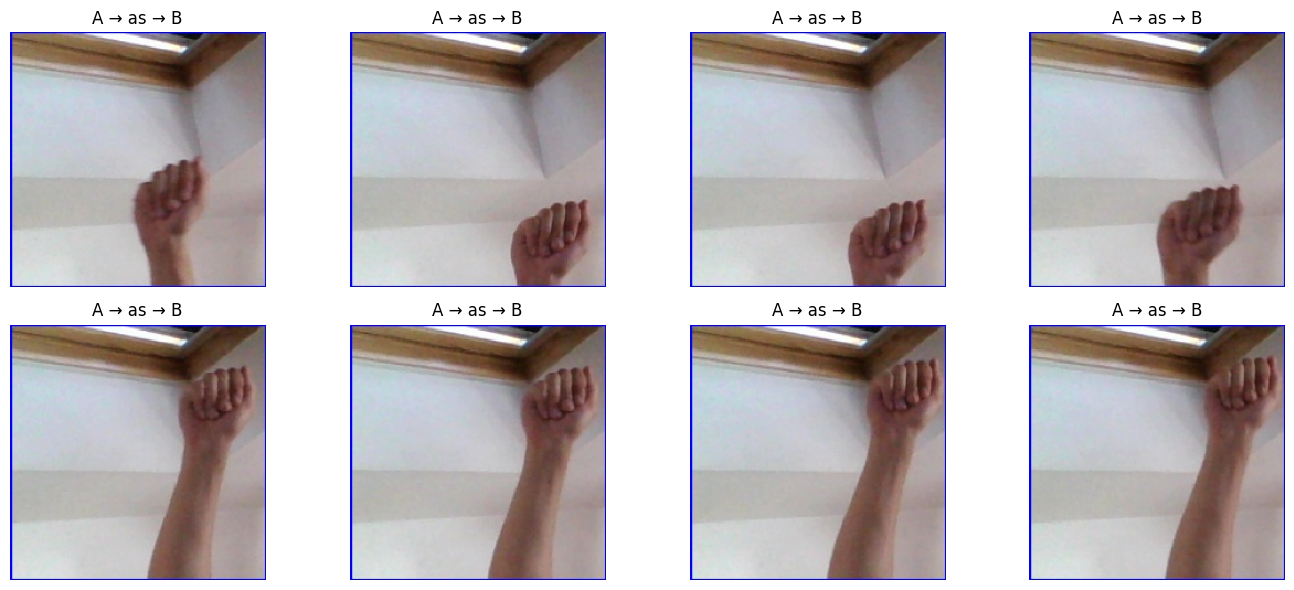

In [30]:
import matplotlib.pyplot as plt
import glob

# show up to 8 example misclassifications
examples = glob.glob(os.path.join(OUT_DIR, "*", "*.jpg"))[:8]
plt.figure(figsize=(14,6))
for i, img_path in enumerate(examples):
    img = image.load_img(img_path, target_size=(IMG, IMG))
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.axis('off')
    # folder name contains true__as__pred, so show that
    label_info = os.path.basename(os.path.dirname(img_path))
    plt.title(label_info.replace("__", " → "))
plt.tight_layout()
plt.show()


In [31]:
# df_acc from earlier (class, support, accuracy). If not present, recreate:
import numpy as np, pandas as pd
classes = list(val_generator.class_indices.keys())
per_class = []
for i, cls in enumerate(classes):
    idxs = np.where(true_labels == i)[0]
    acc = (pred_labels[idxs] == i).sum() / len(idxs) if len(idxs)>0 else np.nan
    per_class.append((cls, len(idxs), acc))
df_acc = pd.DataFrame(per_class, columns=['class','support','accuracy']).sort_values('accuracy')
df_acc.head(10)


class  support  accuracy
20     U      600  0.456667
18     S      600  0.566667
23     X      600  0.585000
25     Z      600  0.626667
22     W      600  0.653333
12     M      600  0.680000
8      I      600  0.701667
15     P      600  0.745000
19     T      600  0.776667
24     Y      600  0.776667

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    brightness_range=(0.6,1.4),
    horizontal_flip=True,
    validation_split=0.2   # keep 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG, IMG),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG, IMG),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 84399 images belonging to 29 classes.
Found 21099 images belonging to 29 classes.


In [42]:
model.save(r"C:\Users\Dell\Documents\ASL_Detection\asl_model_final.h5")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [43]:
# Recompute predictions and df_acc
steps = int(np.ceil(val_generator.samples / val_generator.batch_size))
pred_probs = model.predict(val_generator, steps=steps, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = val_generator.classes

classes = list(val_generator.class_indices.keys())
per_class = []
for i, cls in enumerate(classes):
    idxs = np.where(true_labels == i)[0]
    acc = (pred_labels[idxs] == i).sum() / len(idxs) if len(idxs) > 0 else np.nan
    per_class.append((cls, len(idxs), acc))

df_acc = pd.DataFrame(per_class, columns=['class','support','accuracy']).sort_values('accuracy')
print(df_acc.head(10))


660/660 ━━━━━━━━━━━━━━━━━━━━ 3120s 5s/step
   class  support  accuracy
8      I      600  0.506667
13     N      600  0.531667
25     Z      600  0.566667
15     P      600  0.595000
24     Y      600  0.618333
6      G      600  0.625000
19     T      600  0.670000
20     U     1922  0.685224
22     W      600  0.688333
17     R      600  0.691667
